# 12.1 Categorical Data

This section introduces the pandas **Categorical type** 

I will show how you can achieve **better performance and memory use** in some pandas operations by using it

## Background and Motivation

Frequently, a **column** in a table may **contain repeated instances of a smaller set of distinct values**

We have already seen functions like **unique and value_counts,** which enable us to extract the distinct values from an array and compute their frequencies, respectively:

In [ ]:
import numpy as np; import pandas as pd

In [ ]:
values = pd.Series(['apple', 'orange', 'apple',
                    'apple'] * 2)

In [ ]:
values

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
dtype: object

In [ ]:
pd.unique(values)

array(['apple', 'orange'], dtype=object)

In [ ]:
pd.value_counts(values)

apple     6
orange    2
dtype: int64

Many data systems (for data warehousing, statistical computing, or other uses) have developed **specialized approaches for representing data with repeated values** for more **efficient** storage and computation

In data warehousing, a best practice is to use so called **dimension tables** containing the **distinct values** and storing the **primary observations as integer keys referencing the dimension table:**

In [ ]:
values = pd.Series([0, 1, 0, 0] * 2)

In [ ]:
dim = pd.Series(['apple', 'orange'])

In [ ]:
values

0    0
1    1
2    0
3    0
4    0
5    1
6    0
7    0
dtype: int64

In [ ]:
dim

0     apple
1    orange
dtype: object

We can use the take method to restore the original Series of strings:

In [ ]:
dim.take(values)

0     apple
1    orange
0     apple
0     apple
0     apple
1    orange
0     apple
0     apple
dtype: object

This **representation as integers** is called the **categorical or dictionary-encoded representation**

The array of distinct values can be called the **categories, dictionary, or levels** of the data

In this book we will use the terms **categorical** and **categories**. The **integer values that reference the categories are called the category codes or simply codes**

The categorical representation can yield **significant performance improvements** when you are doing analytics 

You can also **perform transformations on the categories while leaving the codes unmodified**. Some example transformations that can be made at relatively low cost are:

* Renaming categories

* Appending a new category without changing the order or position of the existing categories



## Categorical Type in pandas

pandas has a special **Categorical type** for holding data that uses the **integer-based categorical representation** or **encoding**

Let’s consider the example Series from before:

In [ ]:
fruits = ['apple', 'orange', 'apple', 'apple'] * 2

In [ ]:
N = len(fruits)

In [ ]:
df = pd.DataFrame({'fruit': fruits,
                   'basket_id': np.arange(N),
                   'count': np.random.randint(3, 15, size=N),
                   'weight': np.random.uniform(0, 4, size=N)},
                   columns=['basket_id', 'fruit', 'count', 'weight'])

In [ ]:
df

,basket_id,fruit,count,weight
0,0,apple,13,3.112595
1,1,orange,11,3.343588
2,2,apple,14,3.384695
3,3,apple,11,1.930988
4,4,apple,9,1.423166
5,5,orange,7,3.168640
6,6,apple,14,2.219072
7,7,apple,4,0.319970


**Here, df['fruit'] is an array of Python string objects. We can convert it to categorical by calling:**

In [ ]:
fruit_cat = df['fruit'].astype('category')

In [ ]:
fruit_cat

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

**The values for fruit_cat are not a NumPy array, but an instance of pandas.Categorical:**

In [ ]:
c = fruit_cat.values

In [ ]:
type(c)

pandas.core.arrays.categorical.Categorical

The Categorical object has **categories and codes attributes:**

In [ ]:
c.categories

Index(['apple', 'orange'], dtype='object')

In [ ]:
c.codes

array([0, 1, 0, 0, 0, 1, 0, 0], dtype=int8)

You can convert a **DataFrame column to categorical by assigning the converted result:**

In [ ]:
df['fruit'] = df['fruit'].astype('category')

In [ ]:
df.fruit

0     apple
1    orange
2     apple
3     apple
4     apple
5    orange
6     apple
7     apple
Name: fruit, dtype: category
Categories (2, object): ['apple', 'orange']

**You can also create pandas.Categorical directly from other types of Python sequences:**

In [ ]:
my_categories = pd.Categorical(['foo', 'bar', 'baz', 'foo', 'bar'])

In [ ]:
my_categories

['foo', 'bar', 'baz', 'foo', 'bar']
Categories (3, object): ['bar', 'baz', 'foo']

If you have obtained** categorical encoded data from another source,** you can use the alternative **from_codes constructor:**

In [ ]:
categories = ['foo', 'bar', 'baz']

In [ ]:
codes = [0, 1, 2, 0, 0, 1]

In [ ]:
my_cats_2 = pd.Categorical.from_codes(codes, categories)

In [ ]:
my_cats_2

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo', 'bar', 'baz']

Unless explicitly specified, **categorical conversions assume no specific ordering of the categories**

So the categories array may be in a different order depending on the ordering of the input data

**When using from_codes or any of the other constructors, you can indicate that the categories have a meaningful ordering:**

In [ ]:
ordered_cat = pd.Categorical.from_codes(codes, categories,
                                      ordered=True)

In [ ]:
ordered_cat

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

The output [foo < bar < baz] indicates that 'foo' precedes 'bar' in the ordering, and so on 

**An unordered categorical instance can be made ordered with as_ordered:**

In [ ]:
my_cats_2.as_ordered()

['foo', 'bar', 'baz', 'foo', 'foo', 'bar']
Categories (3, object): ['foo' < 'bar' < 'baz']

As a last note, **categorical data need not be strings,** even though I have only showed string examples

**A categorical array can consist of any immutable value type**

## Computations with Categoricals

Using Categorical in pandas compared with the non-encoded version (like an array of strings) generally behaves the same way

**Some parts of pandas, like the groupby function, perform better when working with categoricals**. There are also some functions that can utilize the ordered flag

Let’s consider some random numeric data, and use the **pandas.qcut binning function**

This return pandas.Categorical; we used pandas.cut earlier in the book but glossed over the details of how categoricals work:


In [ ]:
np.random.seed(12345)

In [ ]:
draws = np.random.randn(1000)

In [ ]:
draws[:5]

array([-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057])

Let’s compute a quartile binning of this data and extract some statistics:

In [ ]:
bins = pd.qcut(draws, 4)

In [ ]:
bins

[(-0.684, -0.0101], (-0.0101, 0.63], (-0.684, -0.0101], (-0.684, -0.0101], (0.63, 3.928], ..., (-0.0101, 0.63], (-0.684, -0.0101], (-2.9499999999999997, -0.684], (-0.0101, 0.63], (0.63, 3.928]]
Length: 1000
Categories (4, interval[float64]): [(-2.9499999999999997, -0.684] < (-0.684, -0.0101] < (-0.0101, 0.63] <
                                    (0.63, 3.928]]

While useful, the exact sample quartiles may be less useful for producing a report than quartile names 

We can achieve this with the **labels argument to qcut:**

In [ ]:
bins = pd.qcut(draws, 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [ ]:
bins

['Q2', 'Q3', 'Q2', 'Q2', 'Q4', ..., 'Q3', 'Q2', 'Q1', 'Q3', 'Q4']
Length: 1000
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

In [ ]:
bins.codes[:10]

array([1, 2, 1, 1, 3, 3, 2, 2, 3, 3], dtype=int8)

**The labeled bins categorical does not contain information about the bin edges in the data, so we can use groupby to extract some summary statistics:**

In [ ]:
bins = pd.Series(bins, name='quartile')

In [ ]:
results = (pd.Series(draws)
           .groupby(bins)
           .agg(['count', 'min', 'max'])
           .reset_index())

In [ ]:
results

,quartile,count,min,max
0,Q1,250,-2.949343,-0.685484
1,Q2,250,-0.683066,-0.010115
2,Q3,250,-0.010032,0.628894
3,Q4,250,0.634238,3.927528


The 'quartile' column in the result retains the original categorical information, including ordering, from bins:

In [ ]:
results['quartile']

0    Q1
1    Q2
2    Q3
3    Q4
Name: quartile, dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

### Better performance with categoricals

If you do a lot of analytics on a particular dataset, converting to categorical can yield substantial overall performance gains

**A categorical version of a DataFrame column will often use significantly less memory,** too

**Let’s consider some Series with 10 million elements and a small number of distinct categories:**

In [ ]:
N = 10000000

In [ ]:
draws = pd.Series(np.random.randn(N))

In [ ]:
labels = pd.Series(['foo', 'bar', 'baz', 'qux'] * (N // 3))

Now we convert labels to categorical:

In [ ]:
categories = labels.astype('category')

Now we note that labels uses significantly more memory than categories:

In [ ]:
labels.memory_usage()

106666784

In [ ]:
categories.memory_usage(c)

13333652

The conversion to category is not free, of course, but it is a one-time cost:

In [ ]:
%time _ = labels.astype('category')

CPU times: user 632 ms, sys: 8.95 ms, total: 641 ms
Wall time: 645 ms


**GroupBy operations can be significantly faster with categoricals because the underlying algorithms use the integer-based codes array instead of an array of strings**

## Categorical Methods

**Series containing categorical data have several special methods similar to the Series.str specialized string methods**

This also provides convenient access to the categories and codes. Consider the Series:

In [ ]:
s = pd.Series(['a', 'b', 'c', 'd'] * 2)

In [ ]:
cat_s = s.astype('category')

In [ ]:
cat_s

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

**The special attribute cat provides access to categorical methods:**

In [ ]:
cat_s.cat.codes

0    0
1    1
2    2
3    3
4    0
5    1
6    2
7    3
dtype: int8

In [ ]:
cat_s.cat.categories

Index(['a', 'b', 'c', 'd'], dtype='object')

**Suppose that we know the actual set of categories for this data extends beyond the four values observed in the data**

We can use the **set_categories** method to change them:

In [ ]:
actual_categories = ['a', 'b', 'c', 'd', 'e']

In [ ]:
cat_s2 = cat_s.cat.set_categories(actual_categories)

In [ ]:
cat_s2

0    a
1    b
2    c
3    d
4    a
5    b
6    c
7    d
dtype: category
Categories (5, object): ['a', 'b', 'c', 'd', 'e']

While it appears that the **data is unchanged,** the **new categories will be reflected in operations that use them**

For example, **value_counts respects the categories,** if present:

In [ ]:
cat_s.value_counts()

d    2
c    2
b    2
a    2
dtype: int64

In [ ]:
cat_s2.value_counts()

d    2
c    2
b    2
a    2
e    0
dtype: int64

In large datasets, categoricals are often used as a convenient tool for memory savings and better performance

**After you filter a large DataFrame or Series, many of the categories may not appear in the data**

To help with this, we can use the **remove_unused_categories method to trim unobserved categories:**

In [ ]:
cat_s3 = cat_s[cat_s.isin(['a', 'b'])]

In [ ]:
cat_s3

0    a
1    b
4    a
5    b
dtype: category
Categories (4, object): ['a', 'b', 'c', 'd']

In [ ]:
cat_s3.cat.remove_unused_categories()

0    a
1    b
4    a
5    b
dtype: category
Categories (2, object): ['a', 'b']

See Table 12-1 for a listing of available categorical methods

Table 12-1. Categorical methods for Series in pandas
<p align='center'>
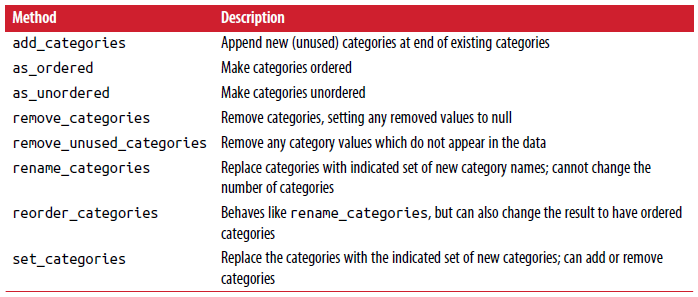
</p>

### Creating dummy variables for modeling

When you’re using statistics or machine learning tools, you’ll often transform categorical data into dummy variables, also known as **one-hot encoding**

This involves **creating a DataFrame with a column for each distinct category;** these columns contain 1s for occurrences of a given category and 0 otherwise

Consider the previous example:

In [ ]:
cat_s = pd.Series(['a', 'b', 'c', 'd'] * 2, dtype='category')

As mentioned previously in Chapter 7, the **pandas.get_dummies** function converts this one-dimensional categorical data into a DataFrame containing the dummy variable:

In [ ]:
pd.get_dummies(cat_s)

,a,b,c,d
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1


# 12.2 Advanced GroupBy Use

## Group Transforms and “Unwrapped” GroupBys

There is another built-in method called **transform,** which is **similar to apply but imposes more constraints on the kind of function you can use:**

* **It can produce a scalar value to be broadcast to the shape of the group**

* **It can produce an object of the same shape as the input group**

* **It must not mutate its input**

Let’s consider a simple example for illustration:

In [ ]:
df = pd.DataFrame({'key': ['a', 'b', 'c'] * 4,
                   'value': np.arange(12.)})

In [ ]:
df

,key,value
0,a,0.0
1,b,1.0
2,c,2.0
3,a,3.0
4,b,4.0
5,c,5.0
6,a,6.0
7,b,7.0
8,c,8.0
9,a,9.0


Here are the group means by key:

In [ ]:
g = df.groupby('key').value

In [ ]:
g.mean()

key
a    4.5
b    5.5
c    6.5
Name: value, dtype: float64

Suppose instead we wanted to **produce a Series of the same shape as df['value'] but with values replaced by the average grouped by 'key'**

**We can pass the function lambda x: x.mean() to transform:**

In [ ]:
g.transform(lambda x: x.mean())

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

For **built-in aggregation functions,** we can pass a **string alias** as with the GroupBy agg method:

In [115]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64

Like apply, **transform works with functions that return Series,** but the **result must be the same size as the input** 

**For example, we can multiply each group by 2 using a lambda function:**

In [117]:
g.transform(lambda x: x * 2)

0      0.0
1      2.0
2      4.0
3      6.0
4      8.0
5     10.0
6     12.0
7     14.0
8     16.0
9     18.0
10    20.0
11    22.0
Name: value, dtype: float64

As a more complicated example, we can compute the ranks in descending order for each group:

In [118]:
g.transform(lambda x: x.rank(ascending=False))

0     4.0
1     4.0
2     4.0
3     3.0
4     3.0
5     3.0
6     2.0
7     2.0
8     2.0
9     1.0
10    1.0
11    1.0
Name: value, dtype: float64

Consider a group transformation function composed from simple aggregations:

In [119]:
def normalize(x):
  return (x - x.mean()) / x.std()

We can obtain equivalent results in this case either using transform or apply:

In [120]:
g.transform(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

In [121]:
g.apply(normalize)

0    -1.161895
1    -1.161895
2    -1.161895
3    -0.387298
4    -0.387298
5    -0.387298
6     0.387298
7     0.387298
8     0.387298
9     1.161895
10    1.161895
11    1.161895
Name: value, dtype: float64

**Built-in aggregate functions like 'mean' or 'sum' are often much faster than a general apply function**

These also have a “fast past” when used with transform. This allows us to perform a so-called unwrapped group operation:

In [122]:
g.transform('mean')

0     4.5
1     5.5
2     6.5
3     4.5
4     5.5
5     6.5
6     4.5
7     5.5
8     6.5
9     4.5
10    5.5
11    6.5
Name: value, dtype: float64